In [34]:
import os
import re
import clip
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import seaborn as sns
#from transformers import AutoConfig, AutoModel, AutoTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPT2ForSequenceClassification

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading Models...")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1').to(device)
sbert_model.eval()
print("Models Loaded: CLIP, SBERT")

Loading Models...
Models Loaded: CLIP, SBERT


In [31]:
def get_clip_embeddings(sentences, batch_size=16):
    tokenized_text = clip.tokenize(sentences).to(device)
    with torch.no_grad():
        clip_embeddings_list = []
        for i in range(0,tokenized_text.size()[0],batch_size):
            tok_batch = tokenized_text[i:i+batch_size]
            clip_embeddings_batch = clip_model.encode_text(tok_batch).to(device)
            for unity in clip_embeddings_batch:
                clip_embeddings_list.append(unity)
    final_emb = torch.stack(clip_embeddings_list)
    return final_emb

def get_sbert_embeddings(sentences):
    with torch.no_grad():  
        sbert_embeddings = torch.from_numpy(sbert_model.encode(sentences))
    return sbert_embeddings

def get_file_path(directory):
    valid_txt = 'valid_sentences.txt'  
    valid_path = os.path.join(directory,valid_txt)
    return valid_path
    
def get_sentences_from_file(filename,maximum):
    sentences = []
    with open(filename, mode='rt', encoding='utf-8') as file_object:
        counter = 0
        for line in file_object:
            if counter >= maximum:
                break
            counter += 1
            sentences.append(line)    
    return sentences

def regexification(sentences):
    regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
    for r in regex:
        sentences = list(map(lambda sentence: re.sub(r, " ", sentence), sentences))
    return sentences

In [85]:
def cosin_calculator(targets, predictions): 
    cosines = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for tar in targets:
        cos_line = []
        for pred in predictions:
            cosine = cos(tar, pred)
            cos_line.append(cosine.item())
        cosines.append(cos_line)
    return torch.tensor(np.array(cosines, dtype=np.float64))

def plot_similarities(similarities, texts, output_path):
    print("-------Plotting similarities-------")
    count = len(texts)
    plt.xticks([])
    plt.close()

    plt.figure(figsize=(20, 14))
    plt.imshow(similarities, vmin=-1.0, vmax=1.0)
    plt.colorbar()

    plt.xticks(range(count), texts, rotation = 90, fontsize = 7)
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.yticks(range(count), texts, fontsize=7)

    for x in range(similarities.shape[1]):
        for y in range(similarities.shape[0]):
            plt.text(x, y, f"{similarities[y, x]:.2f}", ha="center", va="center", size = 2)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count - 0.5, -0.5])

    plt.title(f"Cosine similarity between text embeddings", size=20)
    plt.show()
    #plt.savefig(output_path, dpi = 300)

def get_embeddings(sentences):    
    regular_sentences = regexification(sentences)

    clip_embeddings = get_clip_embeddings(regular_sentences).to(device).to(float)
    sbert_embeddings = get_sbert_embeddings(sentences).to(device).to(float)
    
    #clip_embeddings /= clip_embeddings.norm(dim=-1, keepdim=True)
    #sbert_embeddings /= sbert_embeddings.norm(dim=-1, keepdim=True)
    
    return clip_embeddings, sbert_embeddings
    
def run(directory, maximum, output_path=None, checkpoint_path=None, device=None):
    file= get_file_path(directory)
    sentences = get_sentences_from_file(file,maximum)
    clip_embeddings, sbert_embeddings = get_embeddings(sentences)
    similarities = ( clip_embeddings @ sbert_embeddings.T ).to("cpu")
    print(f'Similarities type: {type(similarities)} and size: {similarities.size()}')
    print(similarities)
    
    cos_similarities = cosin_calculator(sbert_embeddings, sbert_embeddings)
    print(f'Cos similarities type: {type(cos_similarities)} and size: {cos_similarities.size()}')
    print(cos_similarities)
    
    min_sim = torch.min(similarities)
    max_sim = torch.max(similarities)
    #min_max_path = output_path[:output_path.rindex('.')] + ".json"
    #with open(min_max_path, 'w') as f:
    #    json.dump({"min_sim": min_sim.item(), "max_sim": max_sim.item()}, f)
    plot_similarities(cos_similarities, sentences, output_path)

Similarities type: <class 'torch.Tensor'> and size: torch.Size([15, 15])
tensor([[ 0.0182, -0.0362,  0.1679,  0.4669,  0.4788,  0.1194,  0.3156,  0.6290,
          0.1516,  0.4904,  0.0244,  0.4592,  0.2966, -0.5518,  0.1454],
        [-0.5227, -0.0280,  0.0985,  0.2510, -0.1944,  0.1758,  0.2221,  0.0386,
         -0.0380, -0.4106, -0.6710,  0.2666, -0.0572, -0.8386, -0.4935],
        [ 0.1677,  0.1029,  0.1512,  0.6861, -0.1783,  0.0705, -0.0748,  0.2856,
          0.0757, -0.0759,  0.4422,  0.0975,  0.1581, -0.4596, -0.2495],
        [-0.3049, -0.0613,  0.1754,  0.5947,  0.1388,  0.2471,  0.4146,  0.0512,
          0.6771,  0.0253, -0.2655,  0.3177, -0.1967, -0.3527,  0.1118],
        [ 0.0637, -0.0434,  0.2445,  0.1505, -0.0026,  0.0084,  0.2406,  0.1902,
         -0.0111,  0.2566,  0.1424,  0.3323,  0.0658, -0.3824, -0.1384],
        [-0.1842,  0.0021,  0.1332,  0.0353, -0.0497, -0.0558,  0.1264,  0.1552,
          0.2351,  0.0915, -0.1421, -0.0920,  0.0989, -0.3665, -0.0983],
   

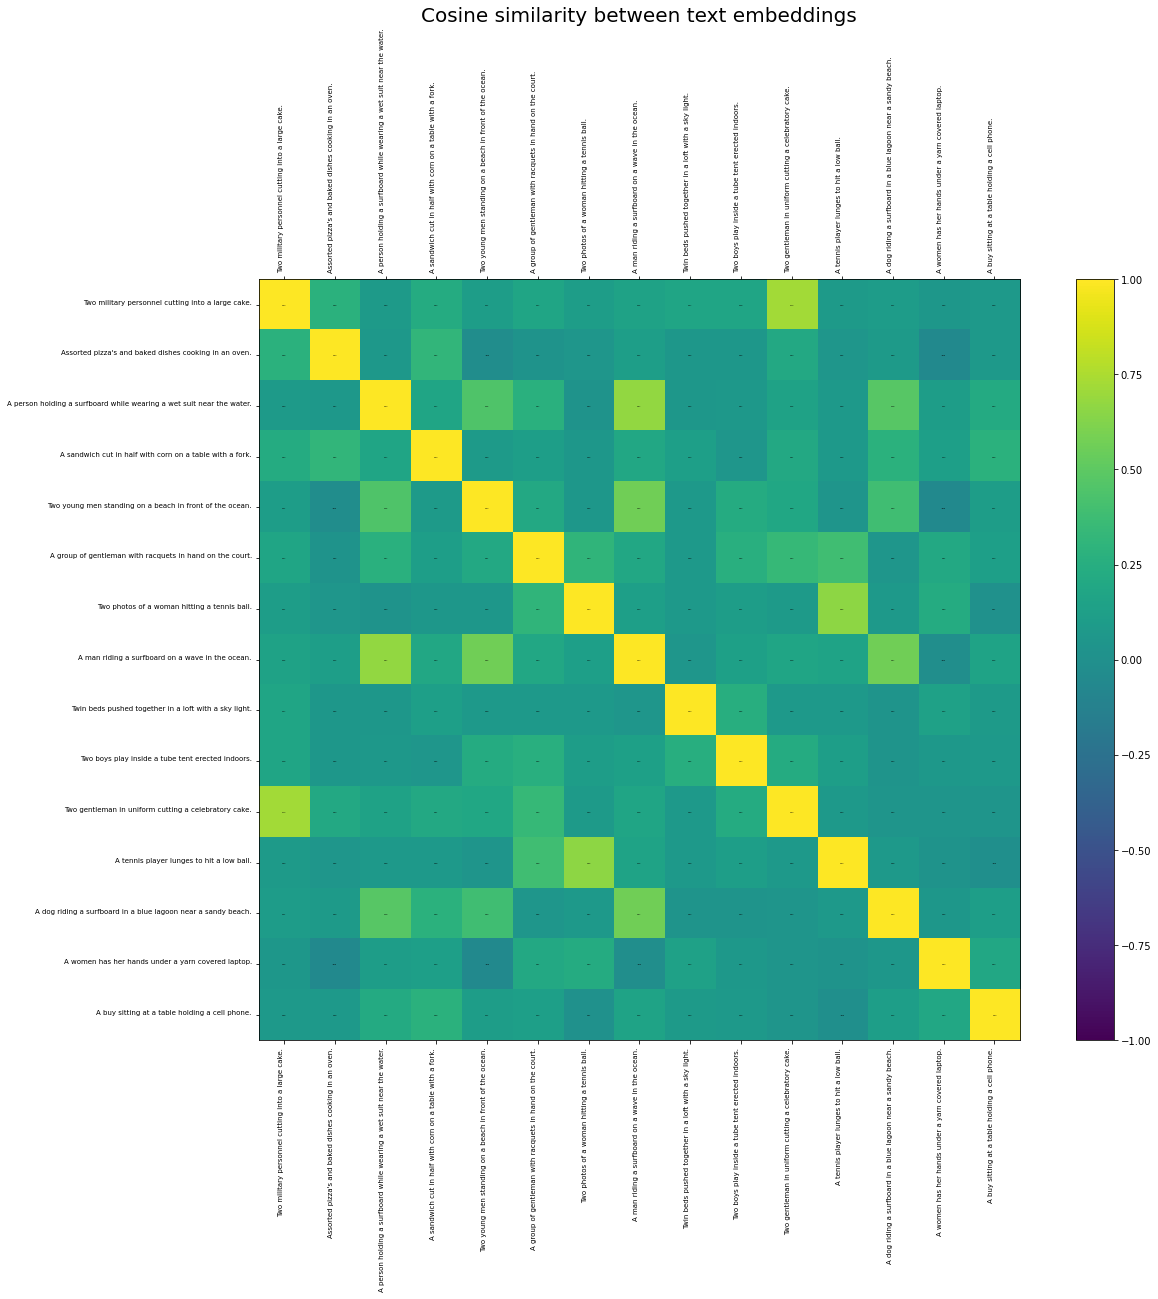

In [87]:
if __name__ == "__main__":
    directory = 'coco'
    #output_path = cfg.OUTPUT
    maximum = 15
    run(directory, maximum, device=device)

In [21]:
directory = 'coco'
file= get_file_path(directory)
sentences = get_sentences_from_file(file,maximum)
clip_embeddings, sbert_embeddings = get_embeddings(sentences)

Loading Models...
Models Loaded: CLIP, SBERT


In [22]:
clip_embeddings.size()

torch.Size([10, 512])

In [23]:
pca = PCA(n_components=3)
clip_Components = pca.fit_transform(clip_embeddings.to("cpu"))
sbert_Components = pca.fit_transform(sbert_embeddings.to("cpu"))

In [24]:
clip_Components[:,0].shape

(10,)

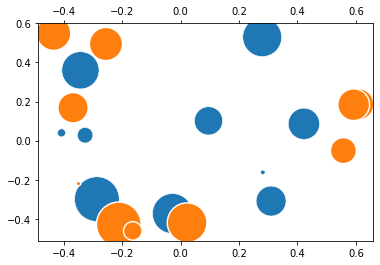

In [26]:
sns.scatterplot(data=clip_Components, x=clip_Components[:,0], y=clip_Components[:,1], size=clip_Components[:,2], legend=False, sizes=(20, 2000))
sns.scatterplot(data=clip_Components, x=sbert_Components[:,0], y=sbert_Components[:,1], size=sbert_Components[:,2], legend=False, sizes=(20, 2000))

# show the graph
plt.show()